In [7]:
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.express as px

from fairadult import Adult, FairMLP

In [8]:
import wandb
run = wandb.init()
artifact = run.use_artifact('davide-sartor-4/fairmlp/model-r5k1m6xr:v0', type='model')
artifact_dir = artifact.download()
run.finish()

wandb:   1 of 1 files downloaded.  


In [9]:
def fairness_penalty(x: torch.Tensor):
    t = torch.linspace(0, 100, 10000).unsqueeze(0).to(x.device)
    # evaluate characteristic functions at t
    phi_empirical = torch.exp(x @ t * 1j).mean(-2)  # (..., eval_points)
    phi_target = torch.exp(-0.5 * (t**2).sum(dim=0))  # (eval_points,)
    return t, phi_empirical, phi_target

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    dm = Adult(batch_size=1024, shuffle=True)
    dm.setup()
    x = torch.stack([x for x, y in list(dm.train_dataloader())[:-1]])
    protected = torch.stack([el[:, 0] for el in x])


print(protected.mean())

tensor(0.6757)


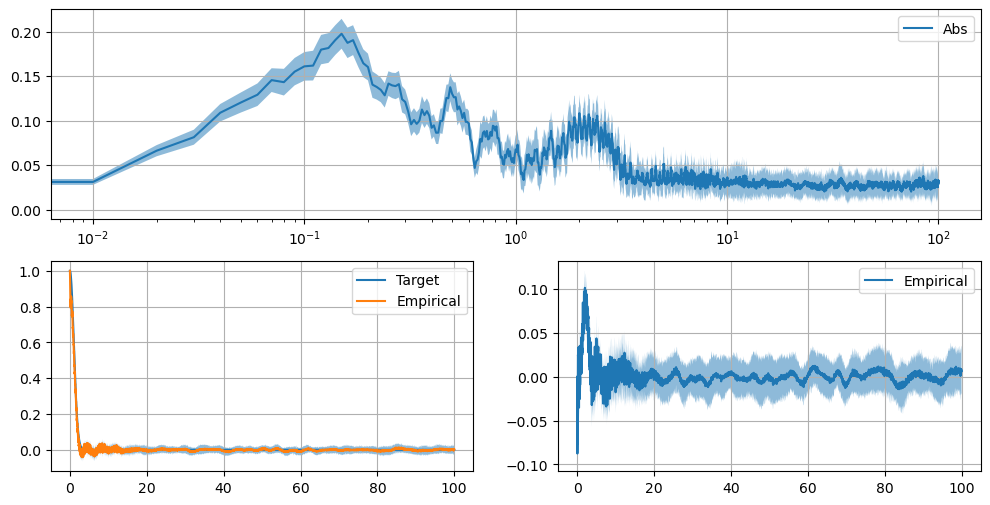

<Figure size 640x480 with 0 Axes>

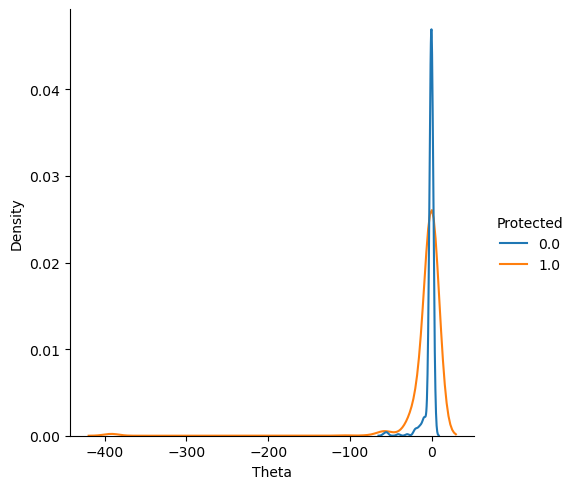

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    dm = Adult(batch_size=1024, shuffle=True)
    dm.setup()

    # unfair_model = FairMLP.load_from_checkpoint("checkpoints/0.0/last.ckpt").cpu()
    model = FairMLP.load_from_checkpoint(f"{artifact_dir}/model.ckpt").cpu()

    x = torch.stack([x for x, y in list(dm.train_dataloader())[:-1]])
    theta = torch.stack([model.encoder(el) for el in x])
    protected = torch.stack([el[:, model.hparams.protected_id] for el in x])

    t, phi_e, phi_t = fairness_penalty(theta.detach().cpu())
    t = t.flatten()

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    delta = (phi_e-phi_t).abs()
    plt.semilogx(t, delta.mean(0), label="Abs")
    plt.fill_between(t, delta.mean(0)-delta.std(0), delta.mean(0) + delta.std(0), alpha=0.5)
    plt.legend()
    plt.grid()
    plt.subplot(223)
    plt.plot(t, phi_t.real, label="Target")
    plt.plot(t, phi_e.real.mean(0), label="Empirical")
    plt.fill_between(t, phi_e.real.mean(0) - phi_e.real.std(0), phi_e.real.mean(0) + phi_e.real.std(0), alpha=0.5)
    plt.legend()
    plt.grid()
    plt.subplot(224)
    plt.plot(t, phi_e.imag.mean(0), label="Empirical")
    plt.fill_between(t, phi_e.imag.mean(0) - phi_e.imag.std(0), phi_e.imag.mean(0) + phi_e.imag.std(0), alpha=0.5)
    plt.legend()
    plt.grid()
    
    plt.figure()
    data = {
        f"Theta": theta[0, :, 0].detach().cpu().numpy(),
        # "Target": target.cpu().detach().numpy(),
        "Protected": protected[0].detach().cpu().numpy(),
    }
    sns.displot(data, x="Theta", hue="Protected", kind="kde", palette="tab10")